In [2]:
import os
import sys
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio

from icecream import ic, colorize as ic_colorize, argumentToString

sns.set_theme(rc={"legend.facecolor": "w"})
mpl.rcParams["pdf.fonttype"] = 42

os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"


# Register a function to summarize numpy array
@argumentToString.register
def argumentToString_ndarray(obj: np.ndarray):
  return (
    f"ndarray, shape={obj.shape}, dtype={obj.dtype}, "
    f"min={obj.min()}, max={obj.max()}"
  )


ic.configureOutput(prefix="⚡ ")
ic.configureOutput(outputFunction=lambda s: print(ic_colorize(s)))

np.set_printoptions(threshold=10, precision=4)

%load_ext autoreload
%autoreload 2

In [3]:
from admice import dataload

In [4]:
dataRoot = os.path.expanduser("~/data/tedho_ad_mice/")
import glob

glob.glob(os.path.join(dataRoot, "*.v7.mat"))

['/Users/djoshea/data/tedho_ad_mice/workspace_28-Jun-2024_old3xtg_mice_2p_data_for_dan.v7.mat',
 '/Users/djoshea/data/tedho_ad_mice/workspace_28-Jun-2024_control_mice_2p_data_for_dan.v7.mat',
 '/Users/djoshea/data/tedho_ad_mice/workspace_29-Jun-2024_eyeblink_datafordan.v7.mat',
 '/Users/djoshea/data/tedho_ad_mice/workspace_28-Jun-2024_young3xtg_mice_2p_data_for_dan.v7.mat']

In [5]:
control_fname = os.path.join(
  dataRoot, "workspace_28-Jun-2024_control_mice_2p_data_for_dan.v7.mat"
)

ld = sio.loadmat(
  control_fname, struct_as_record=True, squeeze_me=True, chars_as_strings=True
)

In [6]:
desc = ld["controlmice"][0]
ic(desc);

⚡ desc: ('mouse id, 2p data by cells x 65 trials x 266 frames at 30fps, tone position '
         'in seconds, puff position in seconds')


In [7]:
mouse = ld["controlmice"][1]
mouse_id = mouse[0]
ic(mouse_id)
data_rtn = mouse[1]
ic(data_rtn.shape)
tone_time = mouse[2]
puff_time = mouse[3]
ic(tone_time / 30.0, puff_time / 30.0)

⚡ mouse_id: 27
⚡ data_rtn.shape: (657, 65, 266)
⚡ tone_time / 30.0: 4.940622067513758
  puff_time / 30.0: 5.780527818991097


(4.940622067513758, 5.780527818991097)

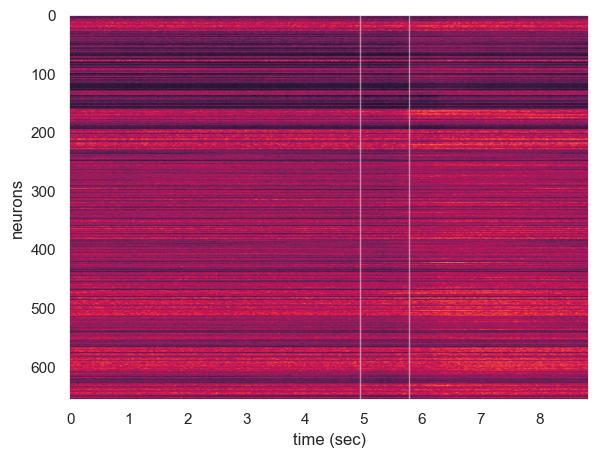

In [8]:
sess = dataload.session_from_mouse_from_matfile(mouse)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sess.heatmap_trialavg(ax)
plt.axvline(sess.tone_time, c=[1, 1, 1, 0.5], linewidth=1, label="tone")
plt.axvline(sess.puff_time, c=[1, 1, 1, 0.5], linewidth=1, label="puff")

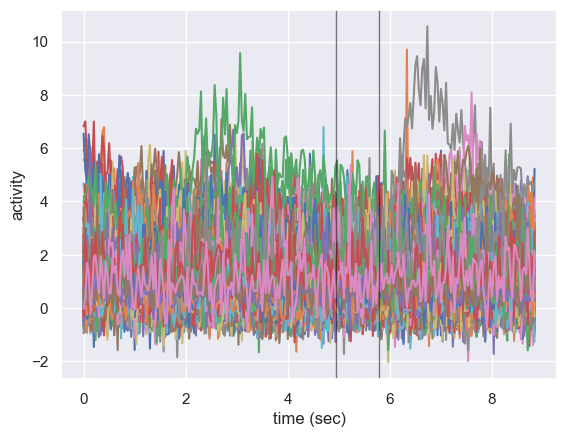

In [9]:
plt.plot(sess.time_sec, sess.data_nrt[:, 3, :].T)
plt.axvline(sess.tone_time, c=[0, 0, 0, 0.5], linewidth=1, label="tone")
plt.axvline(sess.puff_time, c=[0, 0, 0, 0.5], linewidth=1, label="puff")
plt.xlabel("time (sec)")
plt.ylabel("activity");

from Ted:
>then for each trial and each cell, i take the max value in the 850 ms tone response window minus a couple buffer frames (tonemark2pavg+2: tonemark2pavg+25-2 frames), and then i subtract the max value from a similarly sized 22 frame window before the tone. 

## original approach: fixed window around tone, then take subtraction

⚡ tone_resp_orig: ndarray, shape=(657, 65), dtype=float64, min=-3.0927942962392545, max=3.952073425740242


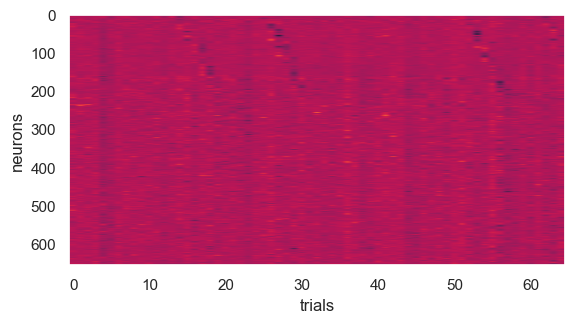

In [12]:
# check with modified above approach
def range_start_n(start, n: int, step=1, limit=None):
  stop = start + step * n
  idx = np.linspace(start, stop, n, endpoint=False)
  if limit is not None:
    mask = (idx >= 0) & (idx < limit)
  else:
    mask = idx >= 0
  return idx[mask]


def range_back_n(stop, n: int, step=1, limit=None):
  start = stop - step * (n - 1)
  idx = np.linspace(start, stop, n, endpoint=True)
  if limit is not None:
    mask = (idx >= 0) & (idx < limit)
  else:
    mask = idx >= 0
  return idx[mask]


tone_ind = sess.tone_time // sess.dt_sec


def calc_tone_delta(
  data,
  tone_ind: int,
  window_buffer: int = 2,
  window_width: int = 21,
  reduce_fn=np.mean,
):
  T = data.shape[-1]
  tone_window = range_start_n(tone_ind + window_buffer, window_width, limit=T).astype(
    int
  )
  tone_max_nr = reduce_fn(data[..., tone_window], axis=-1)

  pre_tone_window = range_back_n(
    tone_ind - window_buffer, window_width, limit=T
  ).astype(int)
  pre_tone_max_nr = reduce_fn(data[..., pre_tone_window], axis=-1)

  tone_delta_nr = tone_max_nr - pre_tone_max_nr
  return tone_delta_nr


tone_resp_orig = calc_tone_delta(sess.data_nrt, tone_ind)
ic(tone_resp_orig)
plt.imshow(tone_resp_orig)
plt.gca().set_aspect(0.05)
plt.grid(False)
plt.xlabel("trials")
plt.ylabel("neurons");

## convolution approach

In [10]:
import numpy as np
from scipy.ndimage import convolve1d


def anchored_convolution(
  data: np.ndarray, kernel: np.ndarray, anchor: int, flip: bool = True, axis: int = -1
) -> np.ndarray:
  # Ensure the anchor is a valid index
  if anchor < 0:
    anchor = anchor + len(kernel)
  if not (0 <= anchor < len(kernel)):
    raise ValueError("Anchor must be a valid index in the kernel.")
  if not flip:
    kernel = np.flip(kernel)

  # Perform the convolution using scipy.ndimage.convolve1d with the origin argument
  origin = (len(kernel) - 1) // 2 - anchor
  convolved = convolve1d(
    data.astype(float),
    kernel.astype(float),
    axis=axis,
    mode="constant",
    cval=np.nan,
    origin=origin,
  )

  return convolved

⚡ filtered: ndarray, shape=(657, 65, 266), dtype=float64, min=nan, max=nan
⚡ tone_resp: ndarray, shape=(657, 65), dtype=float64, min=-3.0927942962392545, max=3.9520734257402417


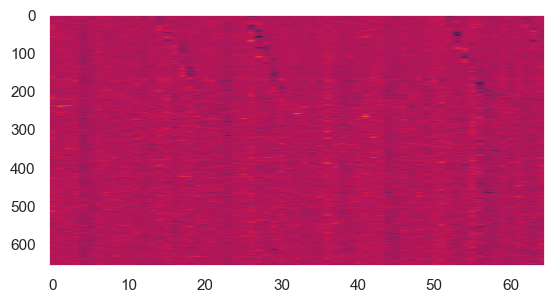

In [11]:
def filter_transients(data, window_width: int = 21, window_buffer: int = 4, axis=-1):
  pos_kernel = np.ones(window_width) / window_width
  pos_response = anchored_convolution(data, pos_kernel, anchor=0, axis=axis)
  neg_kernel = np.concatenate((pos_kernel, np.zeros(window_buffer)))
  neg_response = anchored_convolution(
    data, neg_kernel, anchor=-1, axis=axis, flip=False
  )

  return pos_response - neg_response


filtered = filter_transients(sess.data_nrt)
ic(filtered)
tone_ind = int(sess.tone_time / sess.dt_sec)
tone_resp = filtered[:, :, tone_ind + 2]
ic(tone_resp)
plt.imshow(tone_resp)
plt.gca().set_aspect(0.05)
plt.grid(False)

In [137]:
tone_resp - tone_resp_orig

array([[-1.1102e-16,  2.7756e-17, -2.2204e-16, ..., -2.6645e-15,
        -1.1102e-16,  0.0000e+00],
       [-1.1102e-16,  4.4409e-16,  0.0000e+00, ..., -4.4409e-16,
         1.1102e-16, -2.2204e-16],
       [ 0.0000e+00,  1.6653e-16,  0.0000e+00, ..., -8.8818e-16,
        -2.2204e-16,  0.0000e+00],
       ...,
       [-2.2204e-16,  2.7756e-16,  5.5511e-17, ...,  1.1102e-16,
        -1.7764e-15,  0.0000e+00],
       [-1.1102e-16, -1.1102e-16,  1.1102e-16, ...,  4.4409e-16,
         0.0000e+00,  0.0000e+00],
       [ 2.2204e-16,  0.0000e+00,  0.0000e+00, ..., -4.4409e-16,
        -4.4409e-16,  3.3307e-16]])

In [138]:
# debug with small test data
T = 16
test_data = np.zeros((5, 16))
test_data[...] = np.arange(16)
tone_ind = 7
ic(test_data)

# compute max of data in response window after tone ind
d = calc_tone_delta(test_data, tone_ind, window_buffer=2, window_width=5)
ic(d[0])

f = filter_transients(test_data, window_buffer=4, window_width=5)
ic(f[0, tone_ind + 2])

⚡ test_data: ndarray, shape=(5, 16), dtype=float64, min=0.0, max=15.0
⚡ d[0]: np.float64(8.0)
⚡ f[0,tone_ind+2]: np.float64(8.0)


np.float64(8.0)

# Build LDA decoder

In [139]:
# for each timepoint
#   for each trial:
#     extract that timepoint as the +1 class
#     extract a random, non-overlapping pre-tone timepoint as the -1 class
#   assemble over trials as lda inputs

In [12]:
window_width = 22
window_buffer = 4
filt_nrt = filter_transients(sess.data_nrt, window_buffer=4, window_width=window_width)

pos_ind = tone_ind + 2


def pick_pos_neg_data_for_timepoint(
  filt_nrt: np.ndarray, tone_ind: int, pos_ind: int
) -> tuple[np.ndarray, np.ndarray]:
  pos_data = filt_nrt[:, :, pos_ind]

  # pick random pre-tone, non-overlapping indices for each trial for neg timepoint
  N, R, T = filt_nrt.shape

  valid_mask = np.logical_not(np.isnan(filt_nrt[0, 0]))
  valid_mask[pos_ind : pos_ind + window_width] = (
    False  # disallow idx which overlap with the positive sample and it's averaging window
  )
  valid_mask[tone_ind:] = False  # disallow idx after the tone
  valid_indices = np.where(valid_mask)[0]

  neg_time_idx = np.zeros(R, dtype=int)
  rng = np.random.default_rng(seed=42)
  for i in range(R):
    neg_time_idx[i] = rng.choice(valid_indices)

  # sample the negative timepoint in each trial
  N_idx, R_idx = np.ogrid[:N, :R]
  neg_data = filt_nrt[N_idx, R_idx, neg_time_idx]

  return pos_data, neg_data

In [141]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut, cross_val_score
# from sklearn.metrics import accuracy_score

# Combine data and create labels
pos_ind = tone_ind + 2

pos_data, neg_data = pick_pos_neg_data_for_timepoint(filt_nrt, tone_ind, pos_ind)
R_pos = pos_data.shape[1]
R_neg = neg_data.shape[1]
X = np.hstack((pos_data, neg_data)).T  # Shape (R_pos + R_neg, N)
y = np.hstack((np.ones(R_pos), np.zeros(R_neg)))  # 1 for positive, 0 for negative

# Initialize the LDA classifier
lda = LinearDiscriminantAnalysis()

# Initialize Leave-One-Out cross-validation
loo = LeaveOneOut()

scores = cross_val_score(lda, X, y, cv=loo, scoring="accuracy")
accuracy = np.mean(scores)

print(f"Leave-One-Out Cross-Validation Accuracy: {accuracy:.2f}")

ValueError: a cannot be empty unless no samples are taken

In [178]:
import time
import ray

# Initialize Ray
ray.init(ignore_reinit_error=True)


# Define the function to be parallelized
def square(x):
  time.sleep(2)  # Simulate a time-consuming computation
  return x * x


# Function to process a batch of values
@ray.remote
def process_batch(batch):
  return [square(x) for x in batch]


# Function to split the range into batches and process them
def parallel_square(N, num_batches):
  # Create the list of values
  values = list(range(N))

  # Split values into batches
  batch_size = (
    N + num_batches - 1
  ) // num_batches  # Ceiling division to get batch size
  batches = [values[i : i + batch_size] for i in range(0, N, batch_size)]

  # Process each batch in parallel and wrap with tqdm_ray for progress bar
  result_ids = [process_batch.remote(batch) for batch in batches]
  result_ids = result_ids  # Wrap the result_ids with tqdm_ray for progress bar

  # Gather results
  results = ray.get(result_ids)

  # Flatten the list of lists
  flattened_results = [item for sublist in results for item in sublist]

  return flattened_results


# Example usage
N = 20  # Total number of values
num_batches = 4  # Number of batches to split into

results = parallel_square(N, num_batches)
print(results)

2024-07-17 15:44:55,109	INFO worker.py:1621 -- Calling ray.init() again after it has already been called.


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]


# One more time but do the pos/neg extraction first over all time

⚡ pos_data_nrt: ndarray, shape=(657, 65, 266), dtype=float64, min=nan, max=nan
⚡ neg_data_nrt: ndarray, shape=(657, 65, 266), dtype=float64, min=-4.768566309397655, max=7.08018096309549


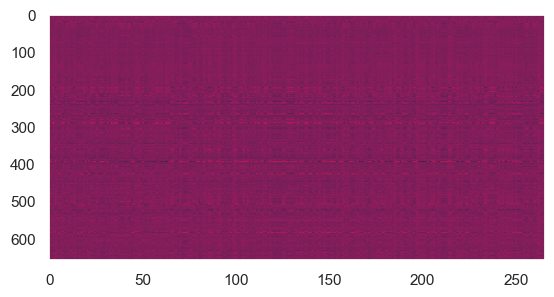

In [ ]:
def pick_pos_neg_data_sliding(
  filt_nrt: np.ndarray, tone_ind: int, exclude_window_width: int, seed: int = 42
) -> tuple[np.ndarray, np.ndarray]:
  pos_data = filt_nrt

  # pick random pre-tone, non-overlapping indices for each trial for neg timepoint
  N, R, T = filt_nrt.shape

  # valid mask is T(as pos_ind) x T(as eligible) mask of eligible timepoints for each trial for the neg sample

  # disallow idx where the filtered data is missing
  valid_mask_tt = np.zeros((T, T), dtype=bool)
  valid_mask_tt[...] = np.logical_not(np.isnan(filt_nrt[0, 0]))

  # disallow idx which overlap with the positive sample (first index)'s averaging window
  for t in range(T):
    valid_mask_tt[t, t : min(t + exclude_window_width, T)] = False

  # disallow idx after the tone
  valid_mask_tt[:, tone_ind:] = False

  # sample the negative timepoint in each trial, for each pos_ind timepoint
  neg_data = np.zeros_like(filt_nrt)
  rng = np.random.default_rng(seed=seed)
  for t in range(T):
    valid_indices = np.where(valid_mask_tt[t, :])[0]
    for r in range(R):
      neg_time_idx = rng.choice(valid_indices)
      neg_data[:, r, t] = filt_nrt[:, r, neg_time_idx]

  return pos_data, neg_data


pos_data_nrt, neg_data_nrt = pick_pos_neg_data_sliding(
  filt_nrt, tone_ind=sess.tone_ind, exclude_window_width=window_width
)
ic(pos_data_nrt)
ic(neg_data_nrt)
plt.imshow(neg_data_nrt[:, 0, :])
plt.gca().set_aspect(0.2)
plt.grid(False)

In [42]:
import ray
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut, cross_val_score


def lda_accuracy(pos_nr: np.ndarray, neg_nr: np.ndarray) -> float:
  R_pos = pos_nr.shape[1]
  R_neg = neg_nr.shape[1]
  X = np.hstack((pos_nr, neg_nr)).T  # Shape (R_pos + R_neg, N)
  y = np.hstack((np.ones(R_pos), np.zeros(R_neg)))  # 1 for positive, 0 for negative

  if np.count_nonzero(np.isnan(X)) > 0:
    return np.nan

  lda = LinearDiscriminantAnalysis()
  loo = LeaveOneOut()
  scores = cross_val_score(lda, X, y, cv=loo, scoring="accuracy")
  accuracy = np.mean(scores)
  return accuracy


# Function to process a batch of values
@ray.remote(num_cpus=1)
def process_batch_lda(
  pos_data_nrt: np.ndarray, neg_data_nrt: np.ndarray, batch_timepoints
):
  return [
    lda_accuracy(pos_data_nrt[:, :, t], neg_data_nrt[:, :, t]) for t in batch_timepoints
  ]


# Function to split the range into batches and process them
def parallel_lda_sliding(
  pos_nrt: np.ndarray, neg_nrt: np.ndarray, num_batches: int = 8
):
  if pos_nrt.shape != neg_nrt.shape:
    raise ValueError("Shapes of pos and neg data do not match")

  T = pos_nrt.shape[2]

  # Create the list of values
  timepoints = list(range(T))

  # Split values into batches
  batch_size = (
    T + num_batches - 1
  ) // num_batches  # Ceiling division to get batch size
  batches = [timepoints[i : min(i + batch_size, T)] for i in range(0, T, batch_size)]

  # Process each batch in parallel
  pos_nrt_ref = ray.put(pos_nrt)  # create reference to large array in object store
  neg_nrt_ref = ray.put(neg_nrt)  # create reference to large array in object store
  result_ids = [
    process_batch_lda.remote(pos_nrt_ref, neg_nrt_ref, batch) for batch in batches
  ]

  # Gather results
  results = ray.get(result_ids)

  # Flatten the list of lists
  flattened_results = [item for sublist in results for item in sublist]

  return flattened_results


pos_data_nrt, neg_data_nrt = pick_pos_neg_data_sliding(
  filt_nrt, tone_ind=sess.tone_ind, exclude_window_width=window_width
)
results = parallel_lda_sliding(pos_data_nrt, neg_data_nrt, num_batches=8)
accuracies = np.array(results)

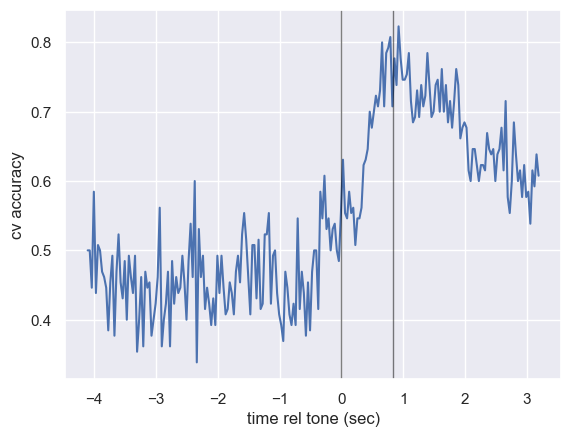

In [43]:
window_width_sec = window_width * sess.dt_sec
t_offset = -sess.tone_time
plt.plot(sess.time_sec + t_offset, np.array(accuracies))

plt.axvline(sess.tone_time + t_offset, c=[0, 0, 0, 0.5], linewidth=1, label="tone")
plt.axvline(sess.puff_time + t_offset, c=[0, 0, 0, 0.5], linewidth=1, label="puff")
plt.xlabel("time rel tone (sec)")
plt.ylabel("cv accuracy");

## Try on multiple control mice

In [1]:
from admice import dataload

ModuleNotFoundError: No module named 'admice'

In [9]:
import scipy.io as sio
from tedho_ad_mice.dataload import session_from_mouse_from_matfile

control_fname = os.path.join(
  dataRoot, "workspace_28-Jun-2024_control_mice_2p_data_for_dan.v7.mat"
)

ld = sio.loadmat(
  control_fname, struct_as_record=True, squeeze_me=True, chars_as_strings=True
)

mice = [session_from_mouse_from_matfile(mouse) for mouse in ld["controlmice"]]

ModuleNotFoundError: No module named 'tedho_ad_mice'

In [ ]:
# Plot the cross-validated accuracy vs. time
plt.figure(figsize=(10, 6))
plt.plot(range(T), accuracies, marker="o")
plt.xlabel("Timepoint")
plt.ylabel("Cross-Validated Accuracy")
plt.title("LDA Cross-Validated Accuracy vs. Time")
plt.grid(True)
plt.show()